# Here is the Step2 about coincidence coding

In [2]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

## Simulated Data Generation

In [ ]:
from matplotlib import gridspec

n_neurons = 20
sig = 2
scale_on = 3
scale_off = 3
n_timesteps = 100
n_samples = 1

# define the probability distribution of ON
def on_prob(k, peak):
    if k <= peak:
        return np.exp(-0.3 * ((k - peak) / sig) ** 2)
    else:
        return np.exp(-2*(k - peak) / scale_on)

# define the probability distribution of OFF
def off_prob(k, peak):
    if k <= peak:
        return np.exp(-0.3 * ((k - peak) / sig) ** 2)
    else:
        return np.exp(-2*(k - peak) / scale_off)

def normalize_probs(prob_fn, max_k):
    raw = np.array([prob_fn(k) for k in range(max_k + 1)])
    return raw / raw.sum()

# calculate overlap
def compute_overlap(on_probs, off_probs):
    overlap = np.minimum(on_probs, off_probs)
    return overlap / overlap.sum()

# generate spike train
def generate_spike_sample(prob_dist):
    spike_train = np.zeros((n_neurons, n_timesteps))
    for t in range(n_timesteps):
        k = np.random.choice(np.arange(n_neurons + 1), p=prob_dist)
        if k > 0:
            active_neurons = np.random.choice(n_neurons, size=k, replace=False)
            spike_train[active_neurons, t] = 1
    return spike_train

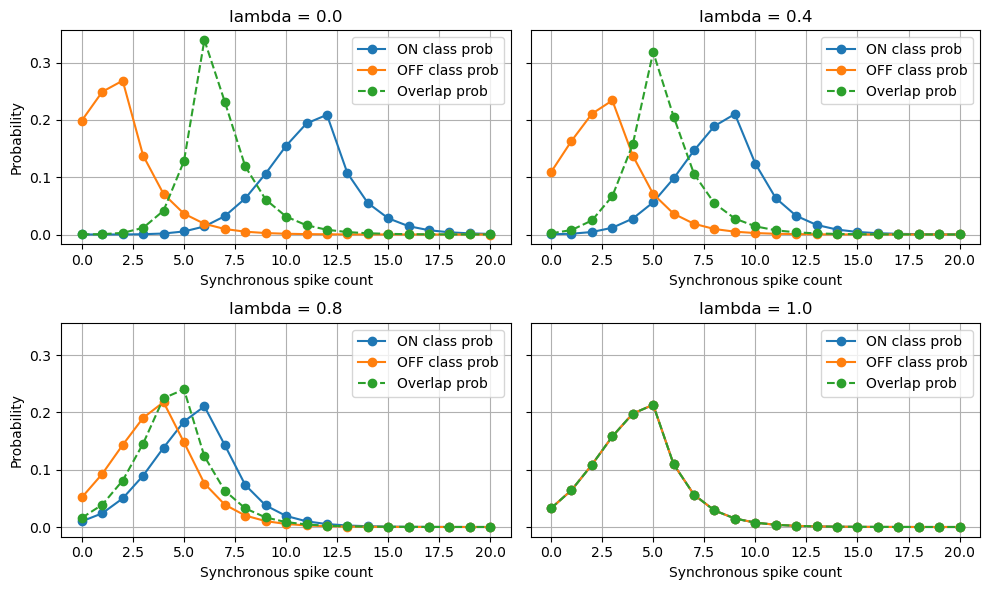

In [ ]:
lambdas = [0.0, 0.4, 0.8, 1.0]
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
axs = axs.flatten() 

for i, lam in enumerate(lambdas):
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5

    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), n_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), n_neurons)
    overlap_probs = compute_overlap(on_probs, off_probs)

    axs[i].plot(on_probs, label="ON class prob", marker='o')
    axs[i].plot(off_probs, label="OFF class prob", marker='o')
    axs[i].plot(overlap_probs, label="Overlap prob", marker='o', linestyle='--')

    axs[i].set_title(f"lambda = {lam}")
    axs[i].set_xlabel("Synchronous spike count")
    axs[i].grid(True)
    if i % 2 == 0:
        axs[i].set_ylabel("Probability")
    axs[i].legend()

plt.tight_layout()
plt.show()


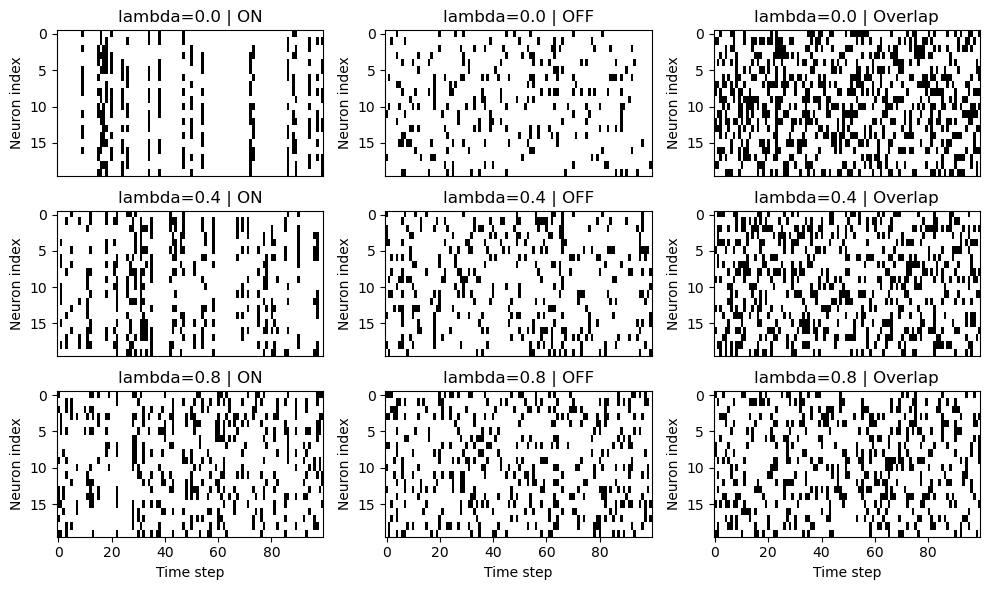

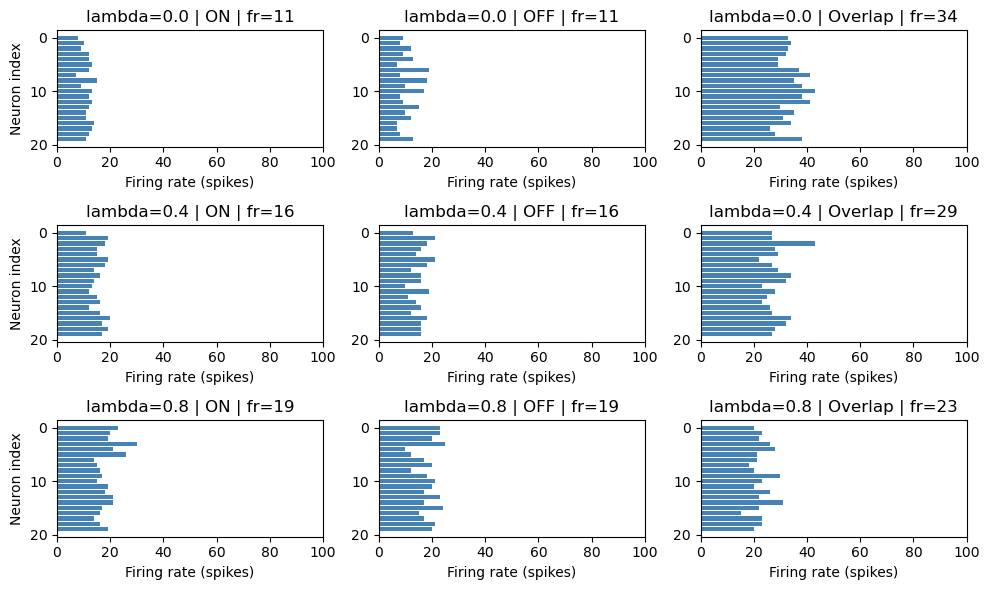

In [ ]:
def generate_spike_sample(prob_dist):
    spike_train = np.zeros((n_neurons, n_timesteps))
    for t in range(n_timesteps):
        k = np.random.choice(np.arange(n_neurons + 1), p=prob_dist)
        if k > 0:
            active_neurons = np.random.choice(n_neurons, size=k, replace=False)
            spike_train[active_neurons, t] = 1
    return spike_train

def remove_spike_columns(spike_train, num_remove):
    timesteps = spike_train.shape[1]
    drop_indices = np.random.choice(timesteps, size=num_remove, replace=False)
    spike_train[:, drop_indices] = 0
    return spike_train

# Visualize Spike train
lambdas = [0.0, 0.4, 0.8]
spike_trains = []

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(len(lambdas), 3)

for row, lam in enumerate(lambdas):
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5

    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), n_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), n_neurons)
    overlap_probs = compute_overlap(on_probs, off_probs)

    on_sample = generate_spike_sample(on_probs)
    off_sample = generate_spike_sample(off_probs)
    overlap_sample = generate_spike_sample(overlap_probs)

    # Calculate firing rate to determine how many columns to remove
    on_rate = on_sample.sum()
    off_rate = off_sample.sum()
    rate_diff = on_rate - off_rate

    avg_spike_per_col = on_sample.sum(axis=0).mean()
    n_remove = int(rate_diff / avg_spike_per_col) if avg_spike_per_col > 0 else 0
    n_remove = max(0, min(n_remove, n_timesteps))

    on_sample = remove_spike_columns(on_sample, n_remove)

    spike_trains.append([on_sample, off_sample, overlap_sample])

    for col, (sample, title) in enumerate(zip(
        [on_sample, off_sample, overlap_sample],
        ["ON", "OFF", "Overlap"]
    )):
        ax = plt.subplot(gs[row, col])
        ax.imshow(sample, aspect='auto', cmap='Greys', interpolation='nearest')
        ax.set_title(f"lambda={lam} | {title}")
        ax.set_ylabel("Neuron index")
        if row == len(lambdas) - 1:
            ax.set_xlabel("Time step")
        else:
            ax.set_xticks([])

plt.tight_layout()
plt.show()

# Visualize Firing rate
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(len(lambdas), 3)

for row, lam_samples in enumerate(spike_trains):
    for col, (sample, title) in enumerate(zip(
        lam_samples,
        ["ON", "OFF", "Overlap"]
    )):
        fr = sample.sum(axis=1)
        mean_fr = sample.sum()/n_neurons
        ax = plt.subplot(gs[row, col])
        y_pos = np.arange(n_neurons)
        ax.barh(y_pos, fr, color='steelblue')
        ax.invert_yaxis()
        ax.set_xlim([0, n_timesteps])
        ax.set_title(f"lambda={lambdas[row]} | {title} | fr={mean_fr:.0f}")
        ax.set_xlabel("Firing rate (spikes)")
        if col == 0:
            ax.set_ylabel("Neuron index")

plt.tight_layout()
plt.show()


Generate dataset and save as .mat

In [ ]:
n_samples_per_class = 1000  # Genearte how many samples in each lambda
lambdas = np.arange(0.0, 1.01, 0.1)  # lambda from 0 to 1 with step 0.1

def generate_spike_sample(prob_dist, num_neurons, T=100):
    spike_train = np.zeros((num_neurons, T), dtype=int)
    for t in range(T):
        k = np.random.choice(np.arange(num_neurons + 1), p=prob_dist)
        if k > 0:
            active_neurons = np.random.choice(num_neurons, size=k, replace=False)
            spike_train[active_neurons, t] = 1
    return spike_train

def remove_spike_columns(spike_train, num_remove):
    T = spike_train.shape[1]
    drop_indices = np.random.choice(T, size=num_remove, replace=False)
    spike_train[:, drop_indices] = 0
    return spike_train

T = 100
num_neurons = 20
X_all = []
Y_all = []
lambda_all = []

label_map = {'OFF': 0, 'ON': 1, 'Overlap': 2}

for lam in lambdas:
    on_mu = (1 - lam) * 12 + lam * 5
    off_mu = (1 - lam) * 2 + lam * 5

    on_probs = normalize_probs(lambda k: on_prob(k, on_mu), num_neurons)
    off_probs = normalize_probs(lambda k: off_prob(k, off_mu), num_neurons)
    overlap_probs = compute_overlap(on_probs, off_probs)

    # Generate a OFF as a reference of firing rate
    ref_off_sample = generate_spike_sample(off_probs, num_neurons, T)
    off_target_rate = ref_off_sample.sum()

    for cls_label, prob_dist in zip(['ON', 'OFF', 'Overlap'], [on_probs, off_probs, overlap_probs]):
        for _ in range(n_samples_per_class):
            spikes = generate_spike_sample(prob_dist, num_neurons, T)

            # Remove some column of ON to make it firing rate ≈ OFF
            if cls_label == 'ON':
                current_rate = spikes.sum()
                rate_diff = current_rate - off_target_rate
                avg_spike_per_col = spikes.sum(axis=0).mean()
                n_remove = int(rate_diff / avg_spike_per_col) if avg_spike_per_col > 0 else 0
                n_remove = max(0, min(n_remove, T))
                spikes = remove_spike_columns(spikes, n_remove)

            # Don't remove column of Overlap
            X_all.append(spikes)
            Y_all.append(label_map[cls_label])
            lambda_all.append(lam)

X_all = np.array(X_all)  # shape (N, num_neurons, T)
Y_all = np.array(Y_all)  # shape (N,)
lambda_all = np.array(lambda_all)  # shape (N,)

print(f"Generated spike trains: {X_all.shape}, Labels: {Y_all.shape}, Lambdas: {lambda_all.shape}")

data_dict = {
    'X': X_all,
    'Y': Y_all,
    'lambda': lambda_all
}

io.savemat('spikedata2.mat', data_dict)
print("Data have been saved in spikedata2.mat")

Generated spike trains: (33000, 20, 100), Labels: (33000,), Lambdas: (33000,)
Data have been saved in spikedata2.mat


X shape = (33000, 20, 100), Y shape = (33000,)


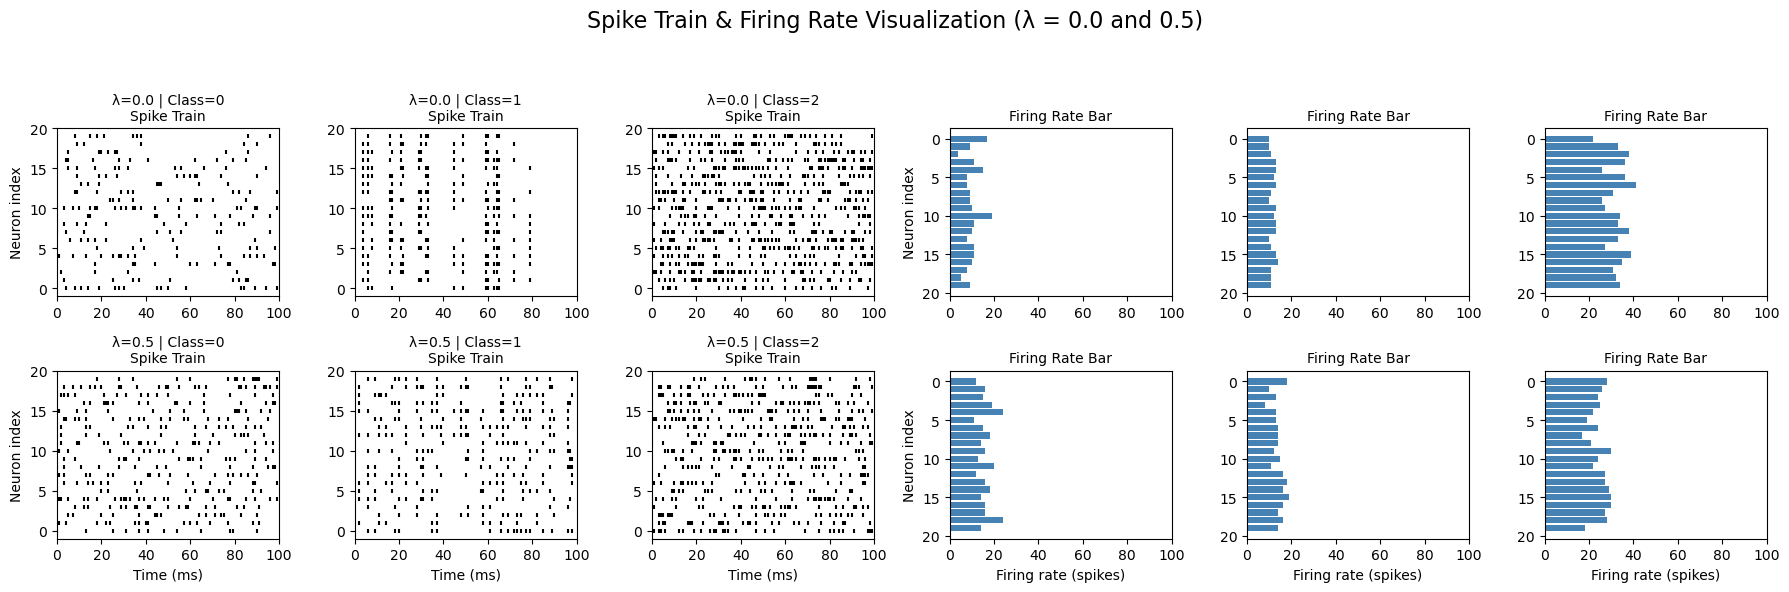

In [ ]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

data = io.loadmat('spikedata2.mat')
X = data['X']  # shape: (N, num_neurons, T)
Y = data['Y'].ravel()  # shape: (N,)
lambdas = data['lambda'].ravel()  # shape: (N,)

N, num_neurons, T = X.shape
print(f"X shape = {X.shape}, Y shape = {Y.shape}")

selected_lambdas = [0.0, 0.5]
class_labels = [0, 1, 2]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18, 6), sharex=False, sharey=False)
fig.suptitle("Spike Train & Firing Rate Visualization (λ = 0.0 and 0.5)", fontsize=16)

for row, lam in enumerate(selected_lambdas):
    for col, cls in enumerate(class_labels):

        indices = np.where((np.isclose(lambdas, lam)) & (Y == cls))[0]
        if len(indices) == 0:
            print(f"No sample found for lambda={lam} and class={cls}")
            continue
        sample_idx = np.random.choice(indices)
        spike_mat = X[sample_idx]

        # (A) Spike raster plot
        ax_spike = axes[row, col]
        for neuron_idx in range(num_neurons):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax_spike.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                             s=5, marker='|', color='k')
        ax_spike.set_title(f"λ={lam:.1f} | Class={cls}\nSpike Train", fontsize=10)
        ax_spike.set_xlim([0, T])
        ax_spike.set_ylim([-1, num_neurons])
        if row == 1:
            ax_spike.set_xlabel("Time (ms)")
        if col == 0:
            ax_spike.set_ylabel("Neuron index")

        # (B) Firing rate bar plot
        ax_fr = axes[row, col + 3]
        fr_each_neuron = spike_mat.sum(axis=1)
        y_positions = np.arange(num_neurons)
        ax_fr.barh(y_positions, fr_each_neuron, color='steelblue')
        ax_fr.invert_yaxis()
        ax_fr.set_xlim([0, T])
        ax_fr.set_title("Firing Rate Bar", fontsize=10)
        if row == 1:
            ax_fr.set_xlabel("Firing rate (spikes)")
        if col == 0:
            ax_fr.set_ylabel("Neuron index")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Split Dataset and Define Help Function


=== lambda = 0.0 可视化 ===


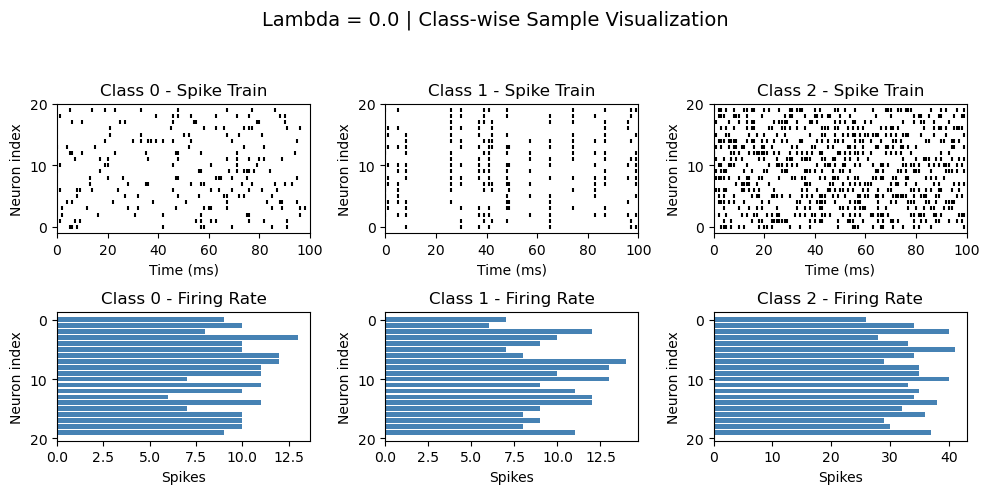


=== lambda = 0.8 可视化 ===


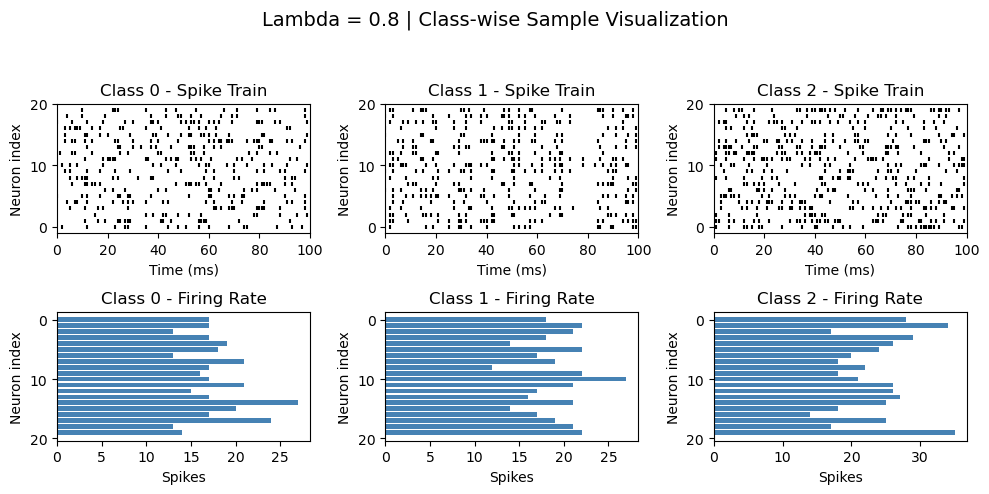

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import torch

data = io.loadmat('spikedata2.mat')
X_all = data['X']  # shape: (N, num_neurons, T)
Y_all = data['Y'].ravel()
lambda_all = data['lambda'].ravel()

num_neurons = X_all.shape[1]
num_classes = 3
lambda_list = np.unique(lambda_all)

def get_split_by_lambda(lam, train_ratio=0.6, val_ratio=0.15, test_ratio=0.15):
    X_train, Y_train = [], []
    X_val, Y_val = [], []
    X_test, Y_test = [], []

    for cls in range(num_classes):
        indices = np.where((np.isclose(lambda_all, lam)) & (Y_all == cls))[0]
        np.random.shuffle(indices)
        n = len(indices)
        if n == 0:
            print(f"⚠️ lambda={lam}, class={cls} has no samples!")
            continue

        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val

        train_idx = indices[:n_train]
        val_idx   = indices[n_train:n_train + n_val]
        test_idx  = indices[n_train + n_val:]

        X_train.extend(X_all[train_idx])
        Y_train.extend(Y_all[train_idx])
        X_val.extend(X_all[val_idx])
        Y_val.extend(Y_all[val_idx])
        X_test.extend(X_all[test_idx])
        Y_test.extend(Y_all[test_idx])

    return (np.array(X_train), np.array(Y_train),
            np.array(X_val), np.array(Y_val),
            np.array(X_test), np.array(Y_test))

def get_batches(X_data, Y_data, batch_size=32, verbose=False, max_num_batches=None, shuffle=True):
    N, num_neurons, num_time_points = X_data.shape
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = N // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    if verbose:
        print(f"batch_size = {batch_size}")
        print(f"num_time_points = {num_time_points}")
        print(f"num_batches = {num_batches}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024**3):.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b * batch_size: (b + 1) * batch_size]
        x_out = torch.tensor(X_data[batch_idx], dtype=torch.float32)
        y_out = torch.tensor(Y_data[batch_idx], dtype=torch.long)
        yield x_out, y_out


lambda_values = [0.0, 0.8]

for lam in lambda_values:
    print(f"\n=== lambda = {lam} ===")
    
    X_lam, Y_lam,_,_,_,_ = get_split_by_lambda(lam)
    T = X_lam.shape[2]

    for batch_x, batch_y in get_batches(X_lam, Y_lam, batch_size=32, max_num_batches=1, shuffle=True):
        break 

    batch_x = batch_x.numpy()
    batch_y = batch_y.numpy()

    selected_samples = []
    for cls in range(num_classes):
        cls_indices = np.where(batch_y == cls)[0]
        if len(cls_indices) > 0:
            selected_idx = np.random.choice(cls_indices)
            selected_samples.append((batch_x[selected_idx], cls))
        else:
            print(f"lambda={lam}, class={cls} has no samples!")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
    fig.suptitle(f"Lambda = {lam} | Class-wise Sample Visualization", fontsize=14)

    for col, (spike_mat, cls_label) in enumerate(selected_samples):
        # spike raster 
        ax_raster = axes[0, col]
        for neuron_idx in range(num_neurons):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax_raster.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                              s=5, marker='|', color='black')
        ax_raster.set_title(f"Class {cls_label} - Spike Train")
        ax_raster.set_xlim([0, T])
        ax_raster.set_ylim([-1, num_neurons])
        ax_raster.set_xlabel("Time (ms)")
        ax_raster.set_ylabel("Neuron index")

        # firing rate bar 
        ax_bar = axes[1, col]
        firing_rates = spike_mat.sum(axis=1)
        ax_bar.barh(np.arange(num_neurons), firing_rates, color='steelblue')
        ax_bar.invert_yaxis()
        ax_bar.set_title(f"Class {cls_label} - Firing Rate")
        ax_bar.set_xlabel("Spikes")
        ax_bar.set_ylabel("Neuron index")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


## Build the Spiking Neural Network Model (SNN)

In [18]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

In [19]:
class SNNLayer(nn.Module):
  def __init__(self, n_in, n_out, spiking=True, **params):
    super(SNNLayer, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    self.w = nn.Parameter(torch.ones((n_in, n_out)))
    self.spiking = spiking
    self.params = dict(
        tau = 20*ms,
        alpha = None,
        dt = 1*ms,
        )
    self.params.update(**params)

  def forward(self, x):
    device = x.device  
    batch_size, num_neurons, num_time_points = x.shape
    assert num_neurons == self.n_in

    v = torch.zeros((batch_size, self.n_out), device=device)
    s = torch.zeros((batch_size, self.n_out), device=device)

    if self.params['alpha'] is not None:
      alpha = self.params['alpha']
    else:
      alpha = np.exp(-self.params['dt'] / self.params['tau'])
    h = torch.einsum('bit,ij->bjt', (x, self.w.to(device))) 

    if self.spiking:
      rec = [s]
    else:
      rec = [v]
    for t in range(num_time_points - 1):
      new_v = (v * alpha + h[:, :, t])
      if self.spiking:
        new_v = new_v * (1 - s)
        s = surrogate_heaviside(v - 1)
      v = new_v
      if self.spiking:
        rec.append(s)
      else:
        rec.append(v)
    y = torch.stack(rec, dim=2)
    return y

class MultilayerSNN(nn.Module):
    def __init__(self, layer_sizes, params):
        super(MultilayerSNN, self).__init__()
        assert layer_sizes[0] == num_neurons and layer_sizes[-1] == num_classes 
        assert len(layer_sizes) - 1 == len(params)

        self.layer_sizes = layer_sizes
        self.params = params
        self.num_layers = len(layer_sizes) - 1

        self.networks = nn.ModuleList()
        for n_in, n_out, p in zip(layer_sizes[:-1], layer_sizes[1:], params):
            net = SNNLayer(n_in, n_out, **p)
            nn.init.uniform_(net.w, *p['w_init'])
            self.networks.append(net)

    def forward(self, x, record=False):
        rec = []
        for net in self.networks:
            x = net(x)
            if record:
                rec.append(x)
        return (x, rec) if record else x

In [ ]:
import torch.nn.functional as F
num_classes = 3

def evaluate_network(net, X_val, Y_val, batch_size=32):
    losses = []
    null_losses = []
    with torch.no_grad():
        for x, y in get_batches(X_val, Y_val, batch_size=batch_size, shuffle=False):
            y_out = net(x)
            y_out_final = y_out[:, :, -1]
            loss = F.cross_entropy(y_out_final, y.long())
            null_loss = F.cross_entropy(torch.zeros_like(y_out_final), y.long())
            losses.append(loss.item())
            null_losses.append(null_loss.item())
    return np.mean(losses), np.mean(null_losses)

def train_model(f, X_train, Y_train, X_val, Y_val,
                num_epochs=30, batch_size=32, max_num_batches=40, 
                lr=0.001, hidden_units=100, device='cuda', seed=42):

    print(f"\n=== Training model with f={f}, num_epochs={num_epochs}, seed={seed} ===")

    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    net = MultilayerSNN((num_neurons, hidden_units, num_classes),
                        [dict(tau=50*ms, w_init=(-0.5, 0.7)),
                         dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01))]).to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    best_model_state = None

    num_train_samples = X_train.shape[0]
    total_batches = num_epochs * (min(num_train_samples // batch_size, max_num_batches) if max_num_batches else num_train_samples // batch_size)

    with tqdm(total=total_batches) as pbar:
        last_epoch_loss = val_loss = null_val_loss = None
        for epoch in range(num_epochs):
            local_loss = []
            for x, y in get_batches(X_train, Y_train, batch_size=batch_size, max_num_batches=max_num_batches, shuffle=True,verbose=(epoch==0)):

                x, y = x.to(device), y.to(device) # move data to device
                y_out = net(x)
                y_out_final = y_out[:, :, -1]
                loss = F.cross_entropy(y_out_final, y.long())
                local_loss.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(1)
                pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)

            last_epoch_loss = np.mean(local_loss)
            val_loss, null_val_loss = evaluate_network(net, X_val, Y_val, batch_size=batch_size)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = net.state_dict()

            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
            loss_hist.append(last_epoch_loss)
            val_loss_hist.append(val_loss)

    plt.figure()
    plt.semilogy(loss_hist, label='Training loss')
    plt.semilogy(val_loss_hist, label='Validation loss')
    plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropy')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if best_model_state is not None:
        net.load_state_dict(best_model_state)
        print(f"Loaded best model with val_loss={best_val_loss:.4f}")

    test_loss, null_test_loss = evaluate_network(net, X_test, Y_test, batch_size=batch_size)
    print(f"test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")

    return net, best_val_loss

def test_accuracy(net, X_test, Y_test, batch_size=128):
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in get_batches(X_test, Y_test, batch_size=batch_size, shuffle=False):
            preds = torch.argmax(net(x)[:, :, -1], dim=1)
            correct += (preds == y).sum().item()
            total += y.shape[0]
    return correct / total if total > 0 else 0.0

def plot_predictions(net, X_test, Y_test, batch_size=8, max_num_batches=1):
    plt.figure(figsize=(16, 6))
    with torch.no_grad():
        x, y = next(get_batches(X_test, Y_test, batch_size=batch_size))
        y_out = net(x)
        loss = F.cross_entropy(y_out[:, :, -1], y.long())
        T_show = x.shape[2]
        for b in range(min(batch_size, 8)):
            plt.subplot(2, 4, b + 1)
            plt.axhline(y[b].item(), color='k', linestyle='--', label='True label')
            for c in range(num_classes):
                class_curve = y_out[b, c, :].cpu().numpy()
                plt.plot(class_curve, label=f'logit class{c}')
            plt.ylim(-5, 5)
            plt.title(f"Sample {b}, True={y[b].item()},Loss={loss.item():.2f}")
            plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


def test_and_visualize_model(net, X_test, Y_test, batch_size=8, max_num_batches=1):
    acc = test_accuracy(net, X_test, Y_test, batch_size=batch_size)
    print(f"Test Accuracy = {acc:.2%}")
    plot_predictions(net, X_test, Y_test, batch_size=batch_size, max_num_batches=max_num_batches)



### Training model for lambda = 0.0 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.0, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


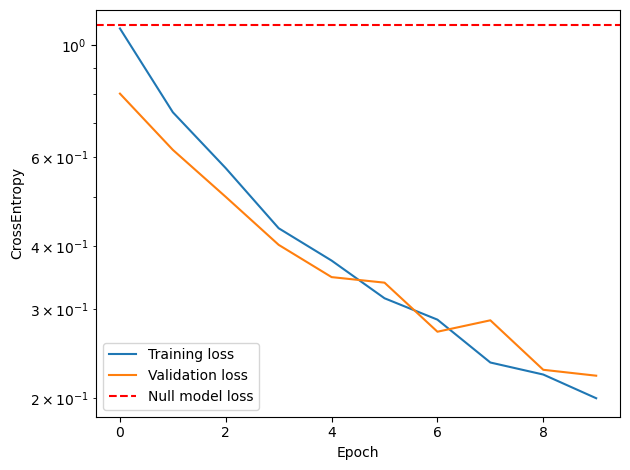

Loaded best model with val_loss=0.2214
test_loss=0.2065, null_test_loss=1.0986
Saved model: zy_f00.pt
Evaluating on test set...
Test Accuracy = 96.24%


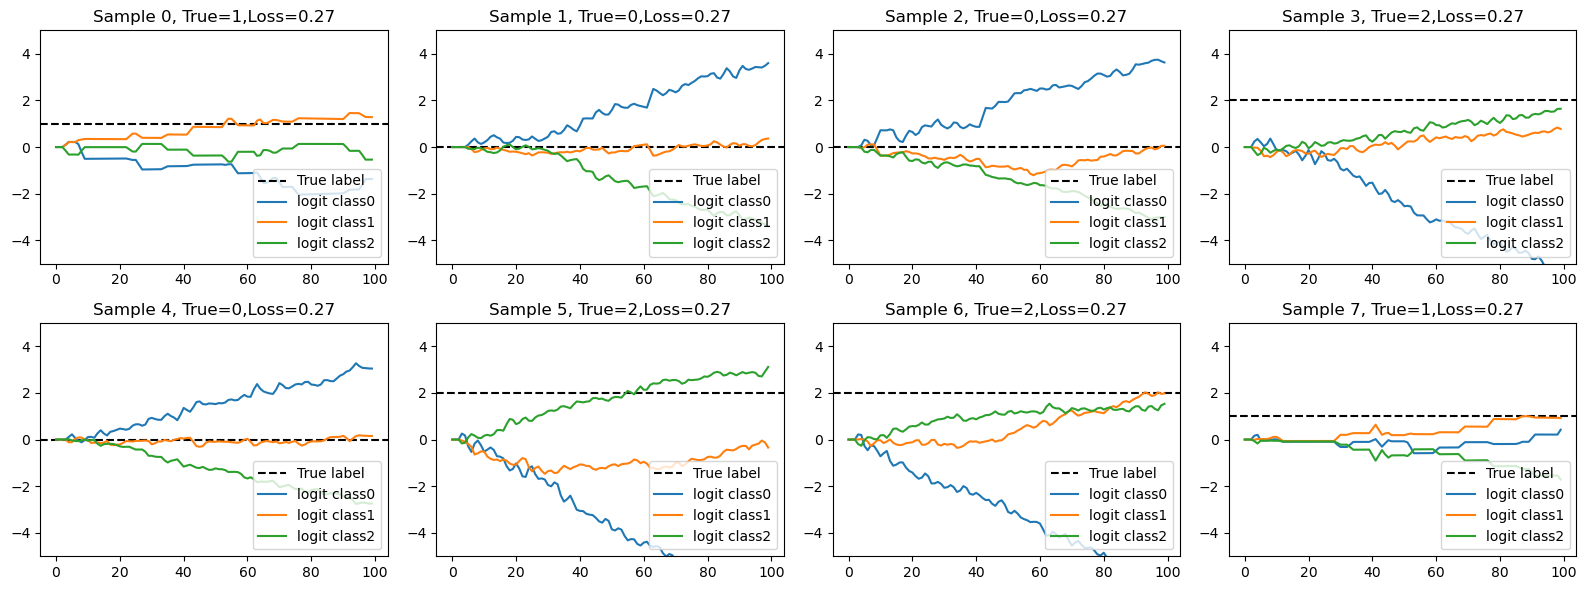

In [ ]:
lambda_values = [0.0]

for lam in lambda_values:
    print(f"\n### Training model for lambda = {lam} ###")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)


    print(f"X_train shape: {X_train.shape}")  # (N_train, num_neurons, T)
    print(f"Y_train shape: {Y_train.shape}")  # (N_train,)
    print(f"Unique labels in Y_train: {np.unique(Y_train)}")

    var_name = f"net_{int(lam * 10):02d}" 
    net, val_loss = train_model(
    f=lam,
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    num_epochs=10
    )

    globals()[var_name] = net

    model_path = f"zy_f{int(lam * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    print("Evaluating on test set...")
    test_and_visualize_model(net, X_test, Y_test)


### Training model for lambda = 0.1 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.1, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


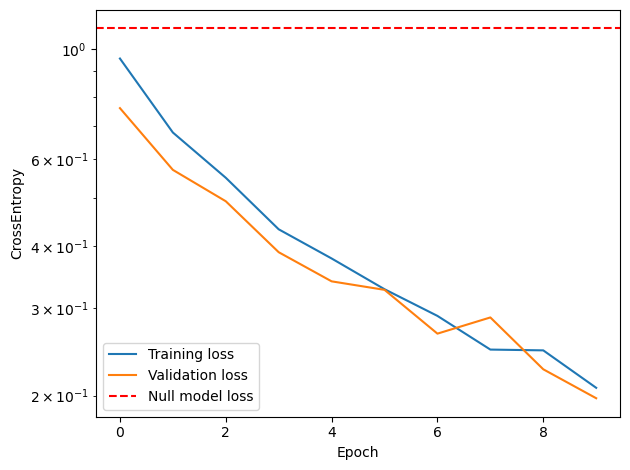

Loaded best model with val_loss=0.1976
test_loss=0.2008, null_test_loss=1.0986
Saved model: zy_f01.pt
Evaluating on test set...
Test Accuracy = 97.18%


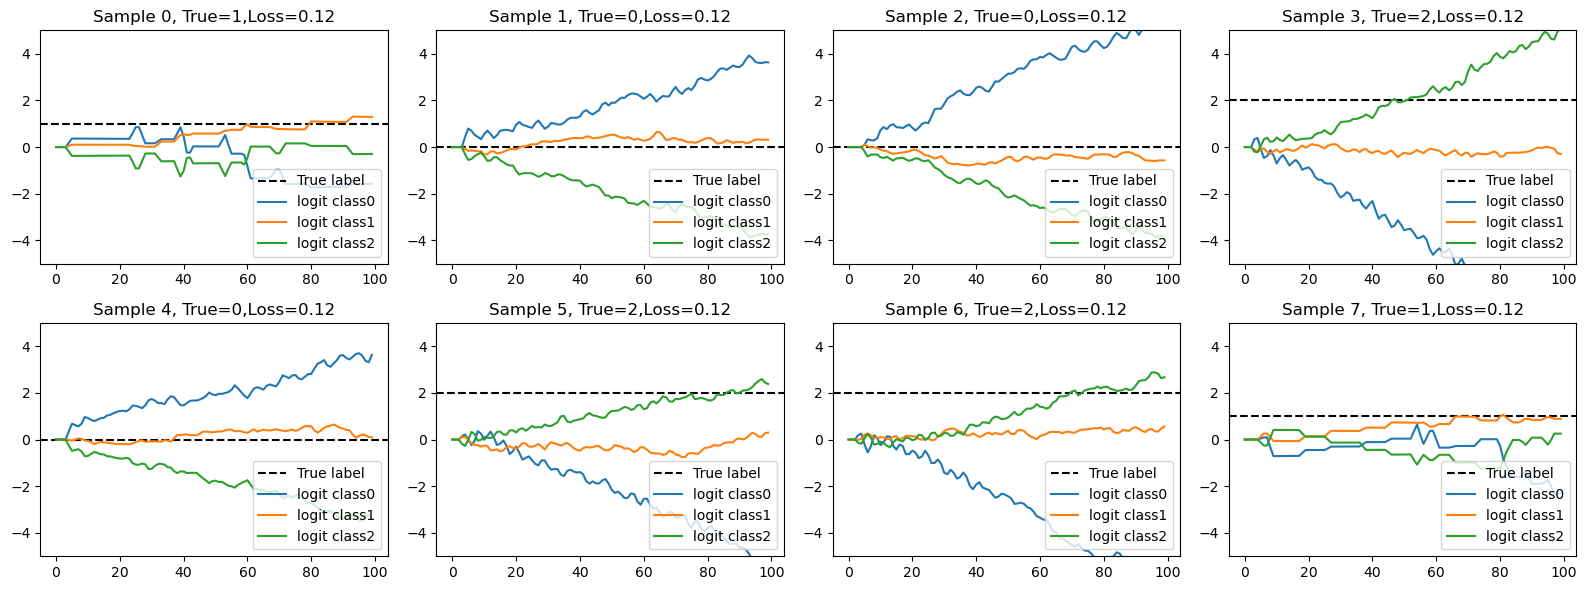


### Training model for lambda = 0.2 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.2, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


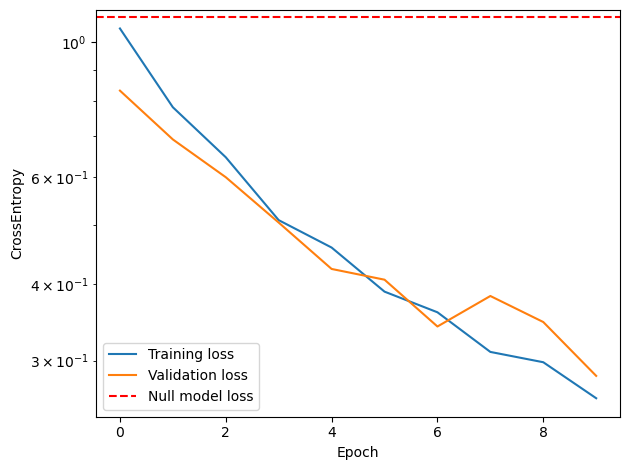

Loaded best model with val_loss=0.2831
test_loss=0.2835, null_test_loss=1.0986
Saved model: zy_f02.pt
Evaluating on test set...
Test Accuracy = 95.83%


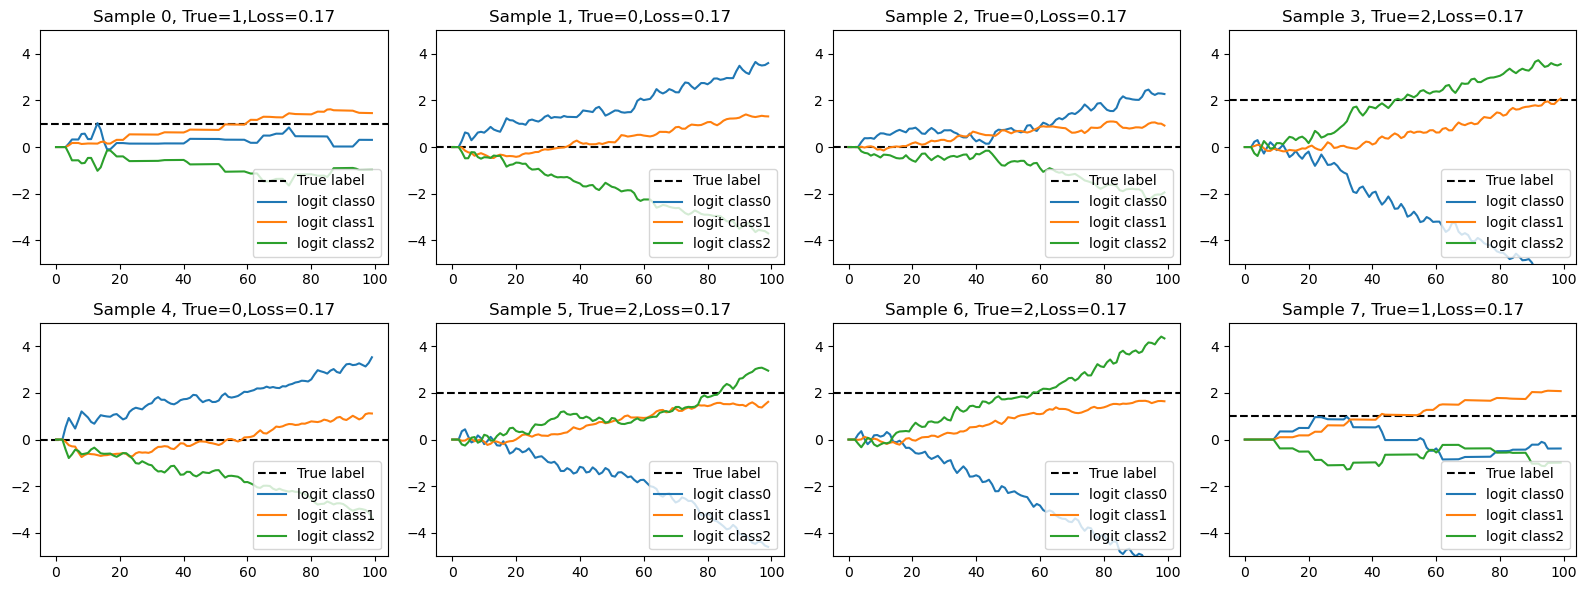


### Training model for lambda = 0.3 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.3, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


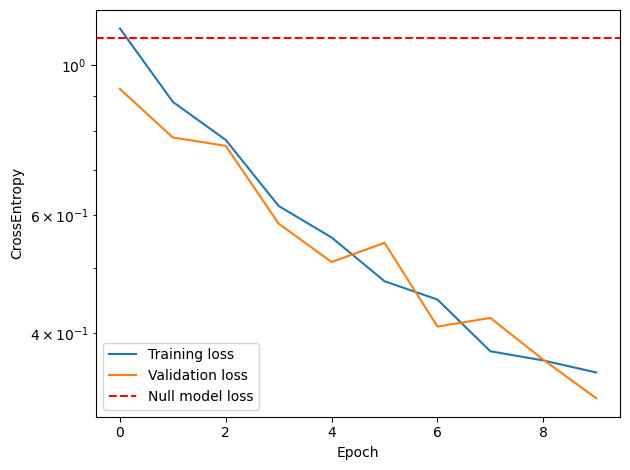

Loaded best model with val_loss=0.3203
test_loss=0.3373, null_test_loss=1.0986
Saved model: zy_f03.pt
Evaluating on test set...
Test Accuracy = 94.22%


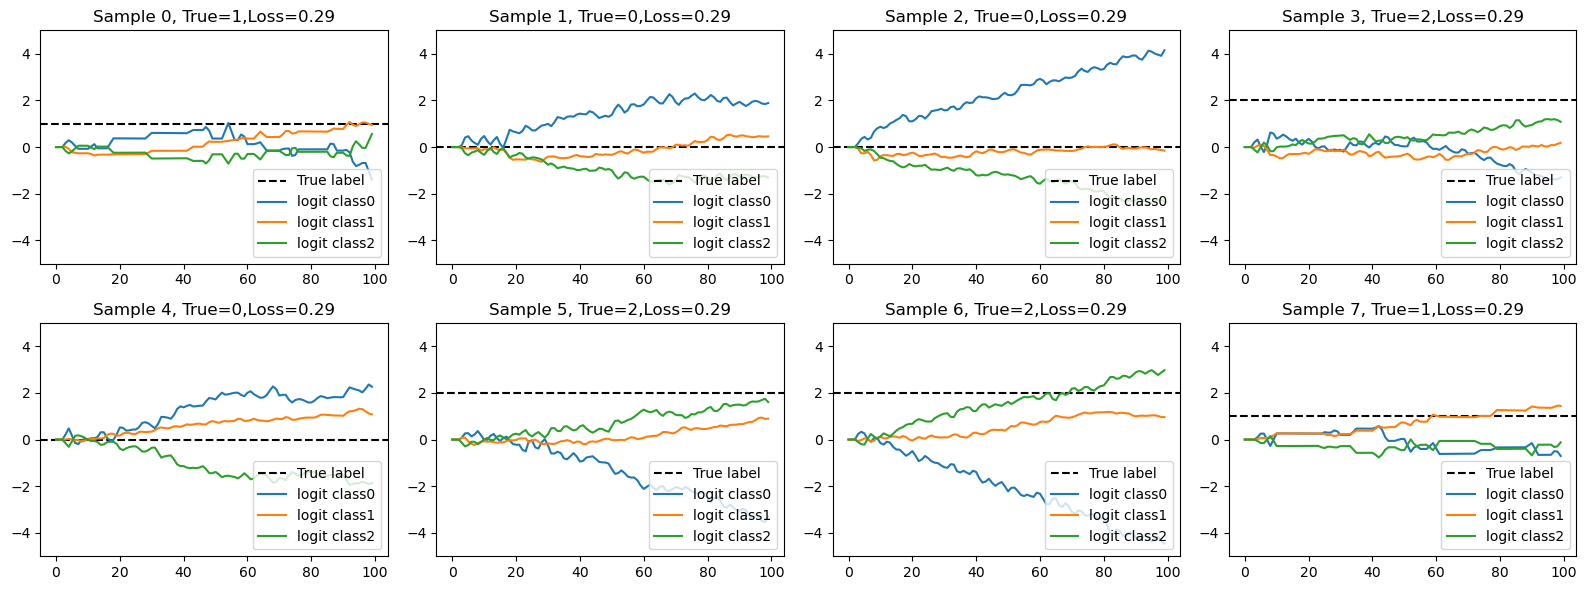


### Training model for lambda = 0.4 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.4, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


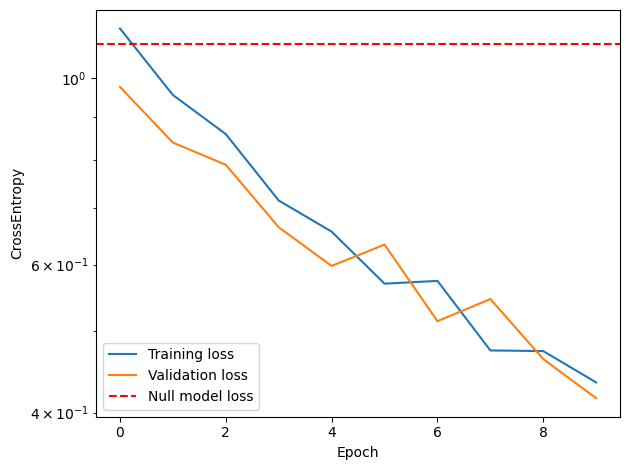

Loaded best model with val_loss=0.4161
test_loss=0.4201, null_test_loss=1.0986
Saved model: zy_f04.pt
Evaluating on test set...
Test Accuracy = 89.65%


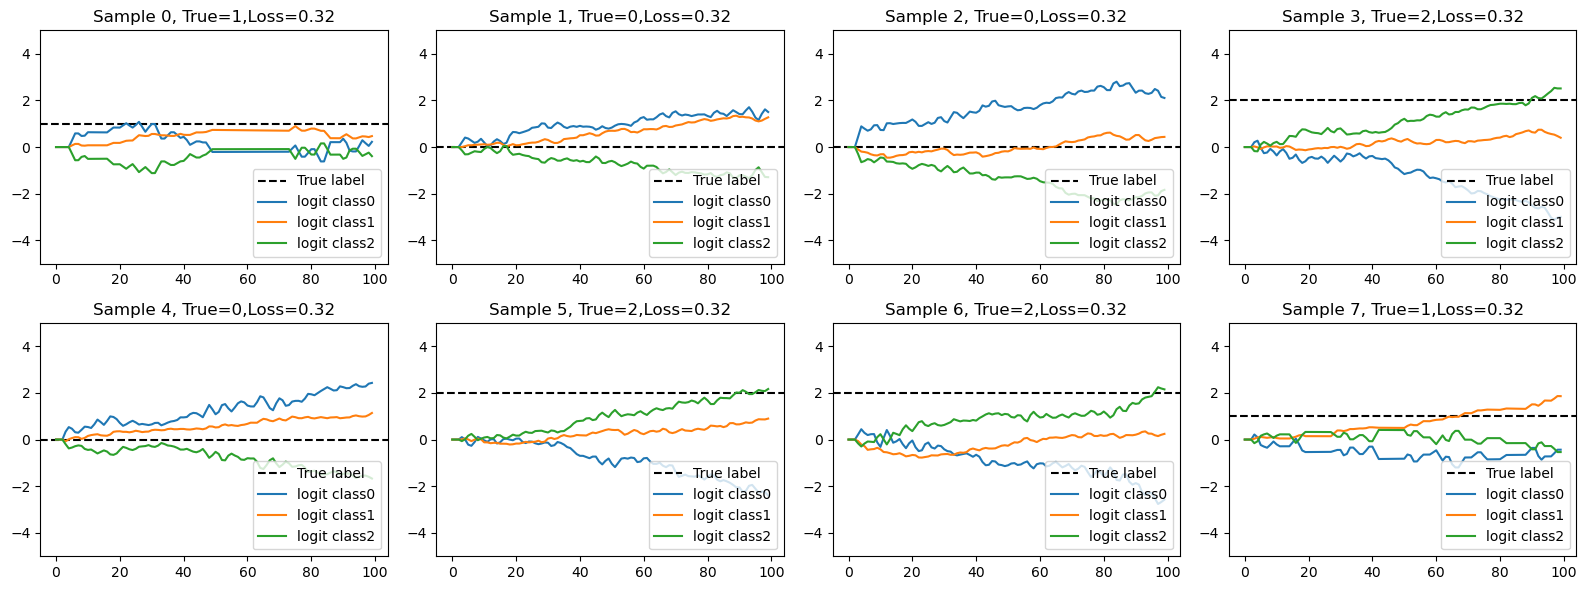


### Training model for lambda = 0.5 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.5, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


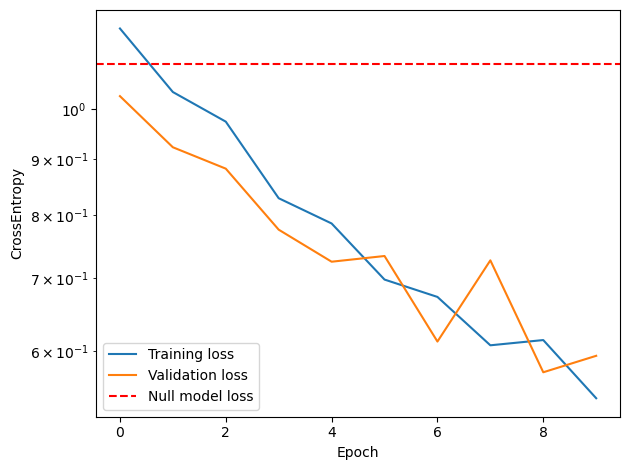

Loaded best model with val_loss=0.5741
test_loss=0.6171, null_test_loss=1.0986
Saved model: zy_f05.pt
Evaluating on test set...
Test Accuracy = 72.85%


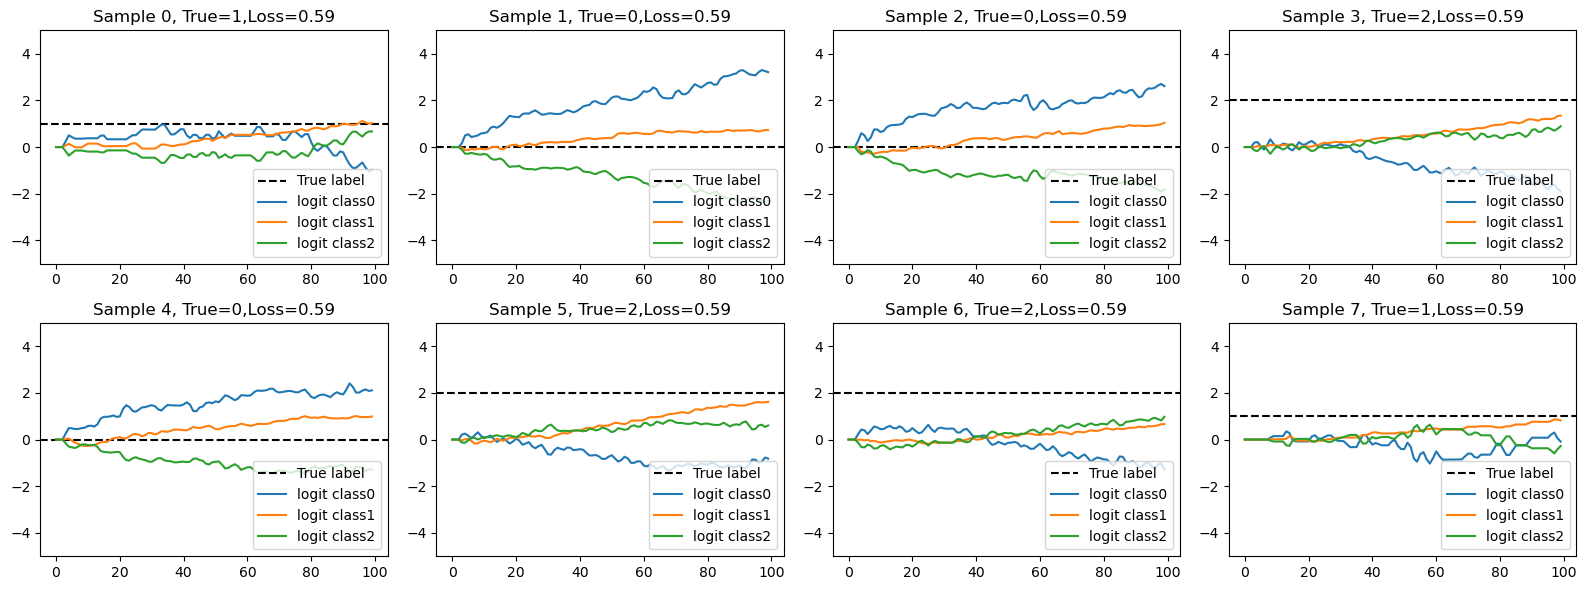


### Training model for lambda = 0.6 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.6, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


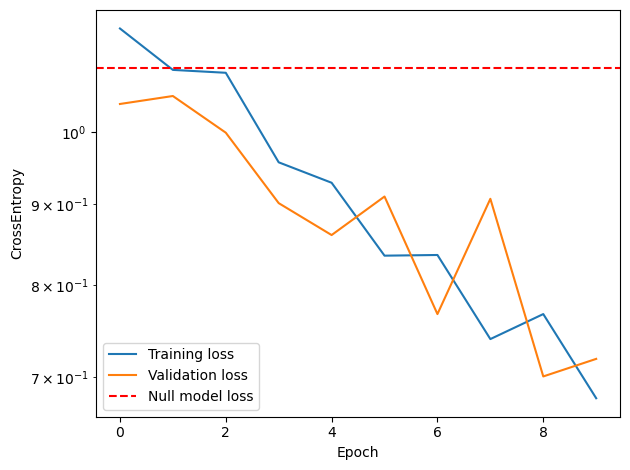

Loaded best model with val_loss=0.7004
test_loss=0.6965, null_test_loss=1.0986
Saved model: zy_f06.pt
Evaluating on test set...
Test Accuracy = 67.88%


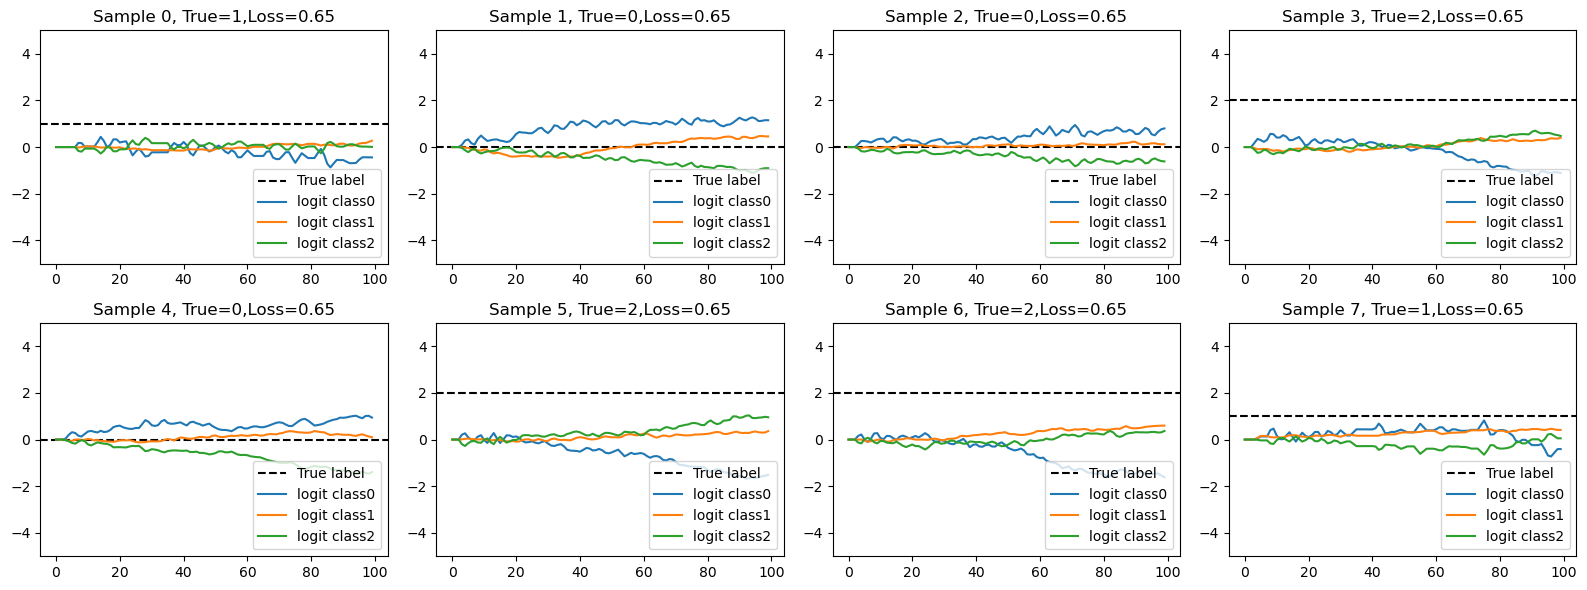


### Training model for lambda = 0.7 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.7, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


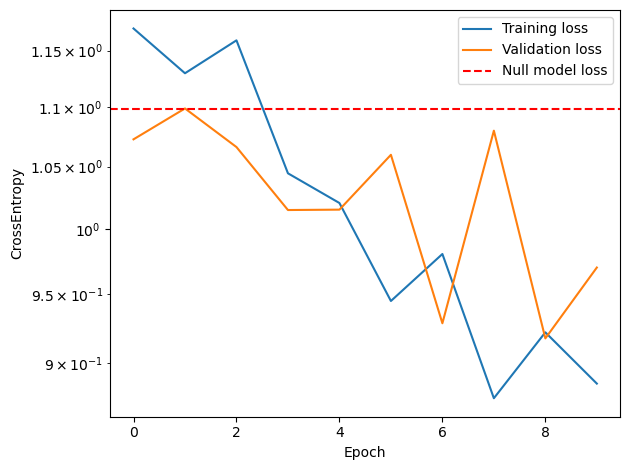

Loaded best model with val_loss=0.9176
test_loss=0.9903, null_test_loss=1.0986
Saved model: zy_f07.pt
Evaluating on test set...
Test Accuracy = 43.95%


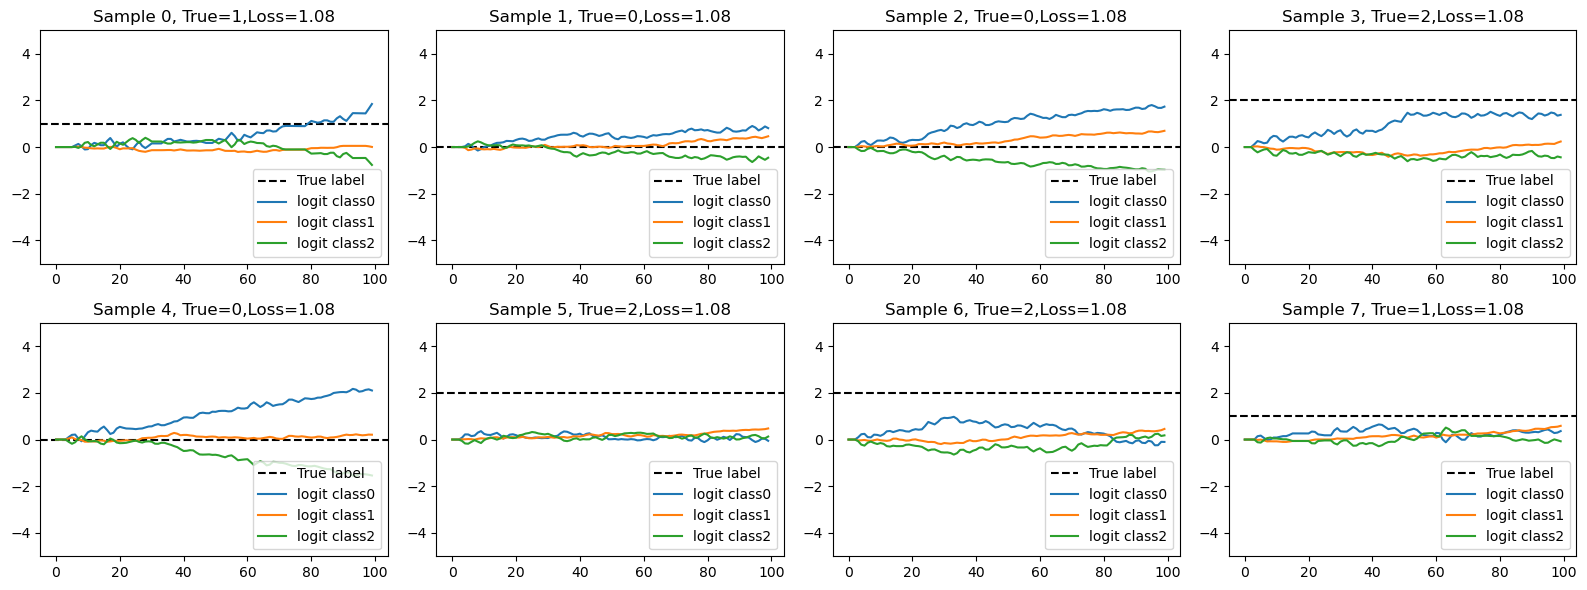


### Training model for lambda = 0.8 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.8, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


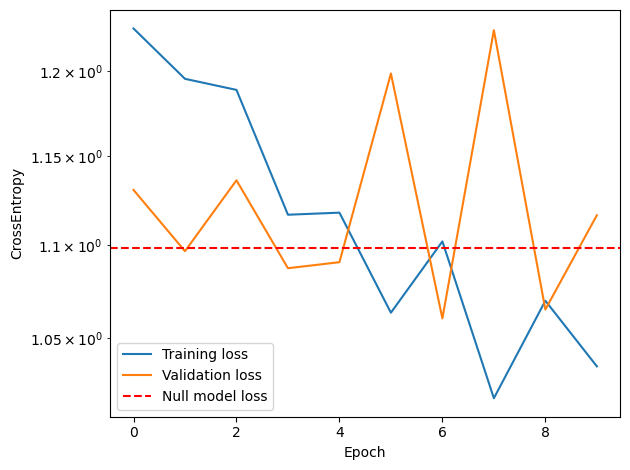

Loaded best model with val_loss=1.0603
test_loss=1.0956, null_test_loss=1.0986
Saved model: zy_f08.pt
Evaluating on test set...
Test Accuracy = 38.84%


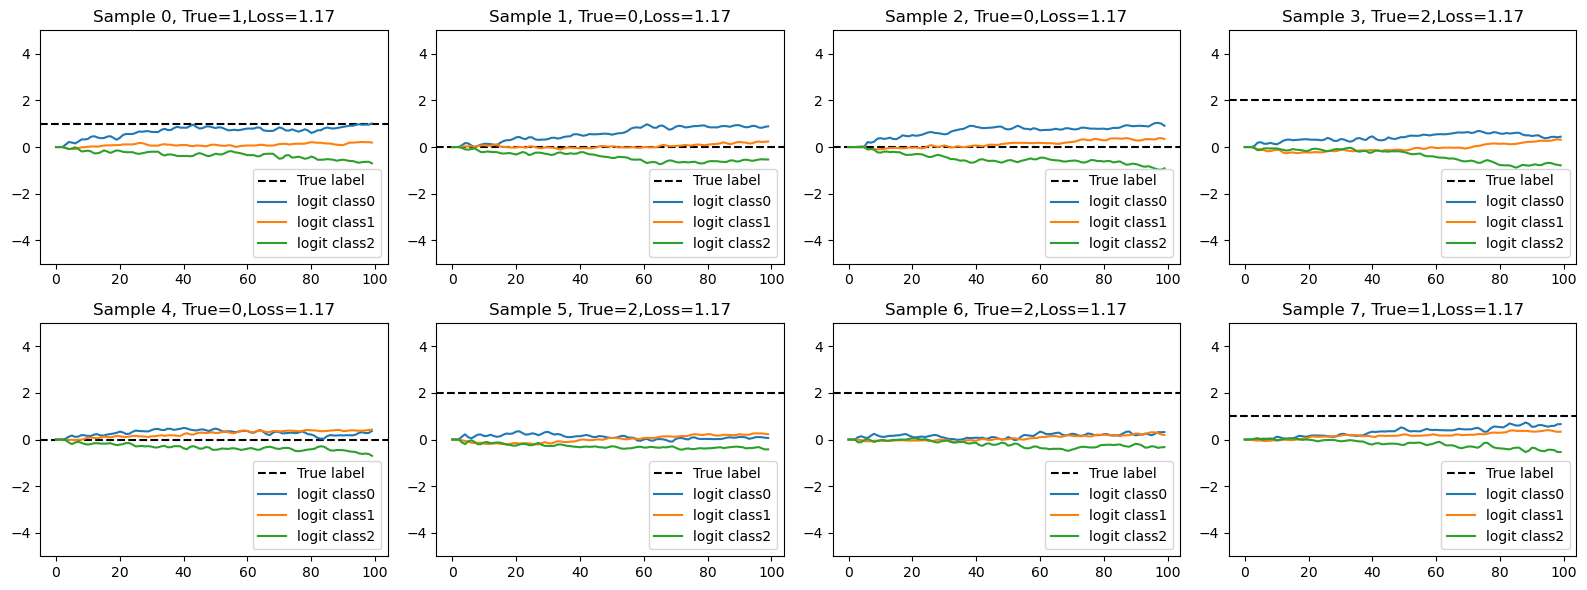


### Training model for lambda = 0.9 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=0.9, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


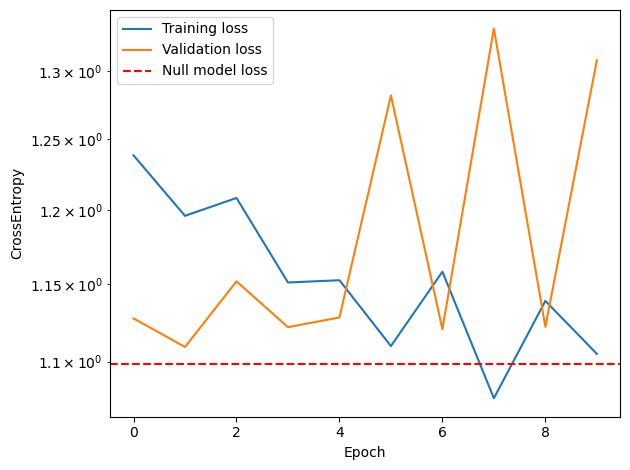

Loaded best model with val_loss=1.1093
test_loss=1.2926, null_test_loss=1.0986
Saved model: zy_f09.pt
Evaluating on test set...
Test Accuracy = 33.74%


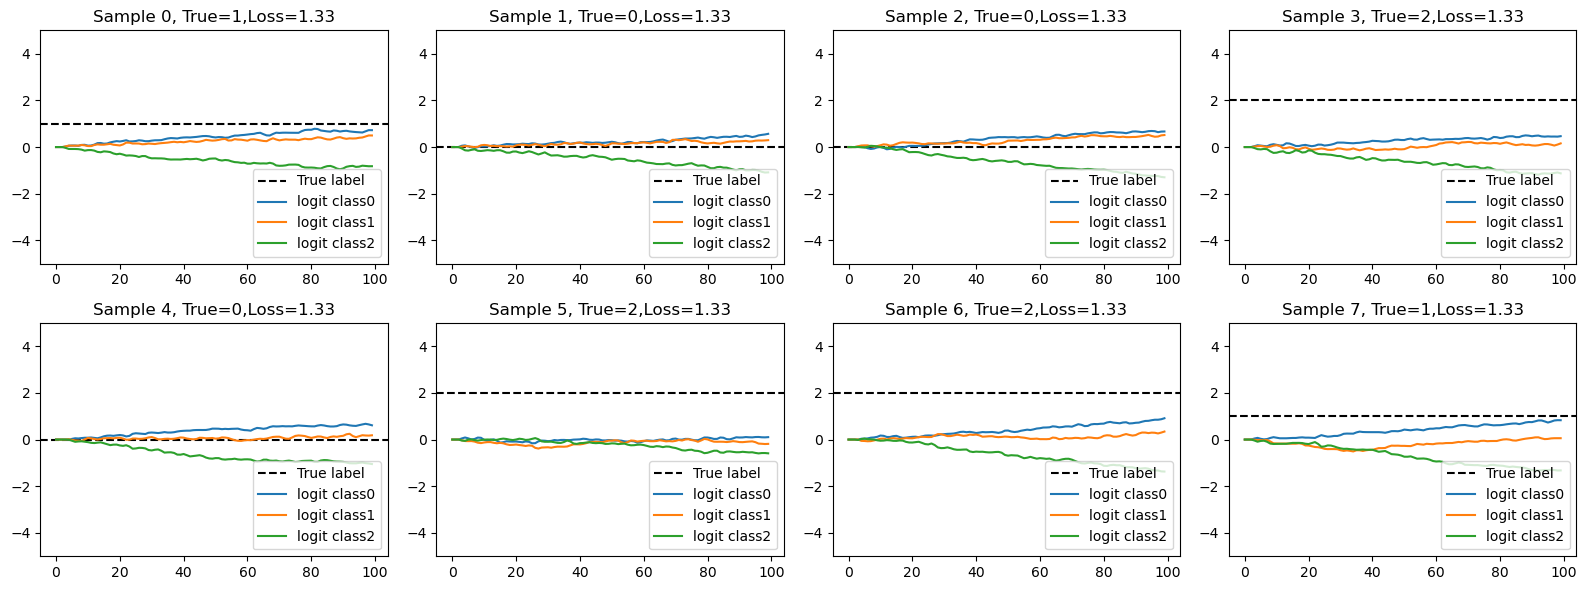


### Training model for lambda = 1.0 ###
X_train shape: (1800, 20, 100)
Y_train shape: (1800,)
Unique labels in Y_train: [0 1 2]

=== Training model with f=1.0, num_epochs=10, seed=42 ===
Using device: cpu


  0%|          | 0/400 [00:00<?, ?it/s]

batch_size = 32
num_time_points = 100
num_batches = 40
RAM usage per batch ~ 0.0005 GB


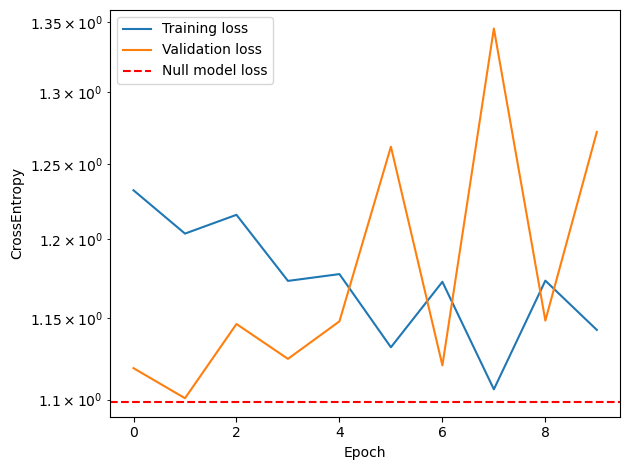

Loaded best model with val_loss=1.1008
test_loss=1.2558, null_test_loss=1.0986
Saved model: zy_f10.pt
Evaluating on test set...
Test Accuracy = 34.54%


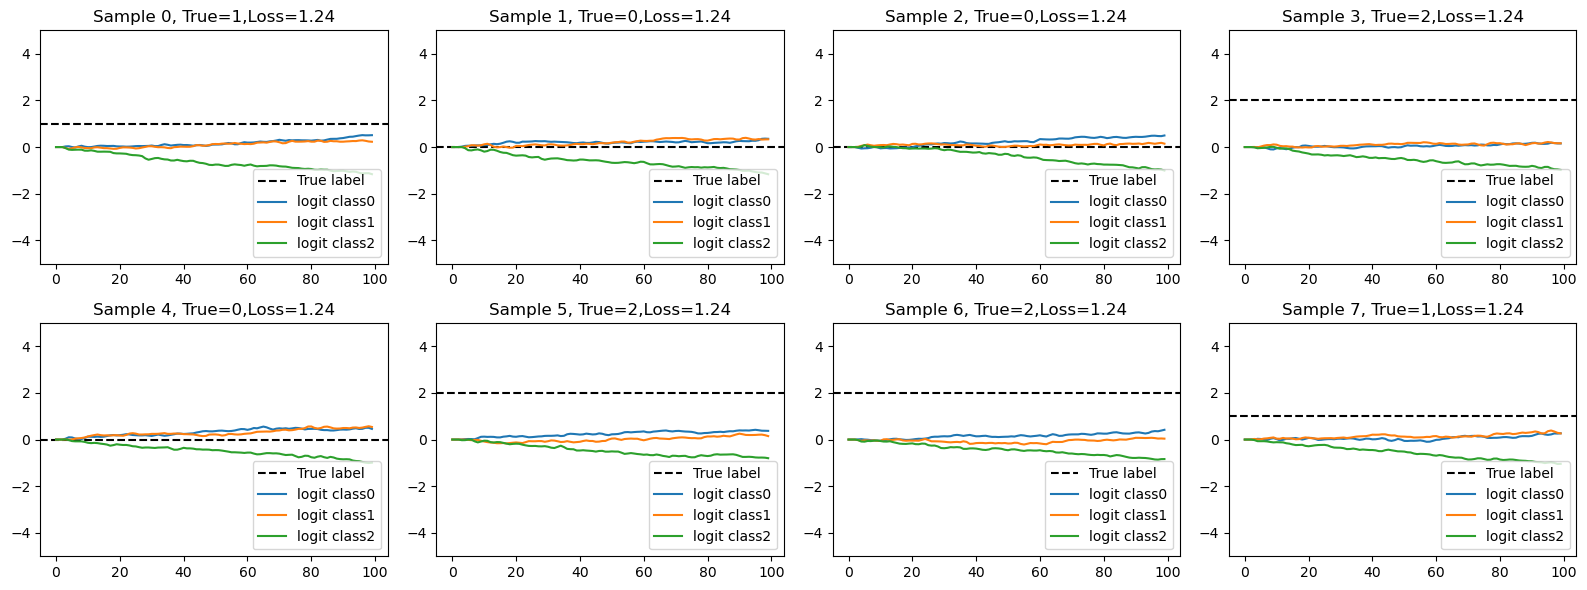

In [ ]:
lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]

for lam in lambda_values:
    print(f"\n### Training model for lambda = {lam} ###")

    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_split_by_lambda(lam)


    print(f"X_train shape: {X_train.shape}")  # (N_train, num_neurons, T)
    print(f"Y_train shape: {Y_train.shape}")  # (N_train,)
    print(f"Unique labels in Y_train: {np.unique(Y_train)}")

    var_name = f"net_{int(lam * 10):02d}" 
    net, val_loss = train_model(
    f=lam,
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    num_epochs=10
    )

    globals()[var_name] = net

    model_path = f"zy_f{int(lam * 10):02d}.pt"
    torch.save(net.state_dict(), model_path)
    print(f"Saved model: {model_path}")

    print("Evaluating on test set...")
    test_and_visualize_model(net, X_test, Y_test)

## Evaluation


=== lamda = 0.0 ===
Test Accuracy: 97.01%

=== lamda = 0.1 ===
Test Accuracy: 97.66%

=== lamda = 0.2 ===
Test Accuracy: 96.64%

=== lamda = 0.3 ===
Test Accuracy: 94.26%

=== lamda = 0.4 ===
Test Accuracy: 90.69%

=== lamda = 0.5 ===
Test Accuracy: 74.15%

=== lamda = 0.6 ===
Test Accuracy: 67.66%

=== lamda = 0.7 ===
Test Accuracy: 46.60%

=== lamda = 0.8 ===
Test Accuracy: 41.37%

=== lamda = 0.9 ===
Test Accuracy: 35.77%

=== lamda = 1.0 ===
Test Accuracy: 37.06%


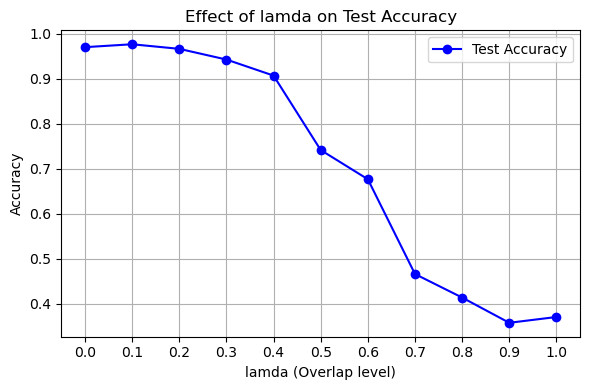

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.io as io

data = io.loadmat('spikedata2.mat') 
X_all = data['X']  # (N, num_neurons, T)
Y_all = data['Y'].ravel()
lambda_all = data['lambda'].ravel()

num_neurons = X_all.shape[1]
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f_values = [0.1 * i for i in range(11)]  # 0.0 ~ 1.0
accuracies = []

for f in f_values:
    print(f"\n=== lamda = {f:.1f} ===")
    net = MultilayerSNN((num_neurons, 100, num_classes),
                        [dict(tau=50 * ms, w_init=(-0.5, 0.7)),
                         dict(tau=500 * ms, spiking=False, w_init=(-0.01, 0.01))])
    net.to(device)

    model_path = f"zy_f{int(f * 10):02d}.pt"
    net.load_state_dict(torch.load(model_path, map_location=device))

    X_test, Y_test = [], []
    for cls in range(num_classes):
        indices = np.where((np.isclose(lambda_all, f)) & (Y_all == cls))[0]
        X_test.extend(X_all[indices])
        Y_test.extend(Y_all[indices])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    acc = test_accuracy(net, X_test, Y_test, batch_size=128)
    accuracies.append(acc)
    print(f"Test Accuracy: {acc:.2%}")

plt.figure(figsize=(6, 4))
plt.plot(f_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")

plt.xlabel("lamda (Overlap level)")
plt.ylabel("Accuracy")
plt.title("Effect of lamda on Test Accuracy")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== lambda = 0.0 ===
Test Accuracy: 97.00%

=== lambda = 0.1 ===
Test Accuracy: 97.67%

=== lambda = 0.2 ===
Test Accuracy: 96.57%

=== lambda = 0.3 ===
Test Accuracy: 94.33%

=== lambda = 0.4 ===
Test Accuracy: 90.80%

=== lambda = 0.5 ===
Test Accuracy: 73.47%

=== lambda = 0.6 ===
Test Accuracy: 67.10%

=== lambda = 0.7 ===
Test Accuracy: 45.97%

=== lambda = 0.8 ===
Test Accuracy: 40.63%

=== lambda = 0.9 ===
Test Accuracy: 35.10%

=== lambda = 1.0 ===
Test Accuracy: 36.37%


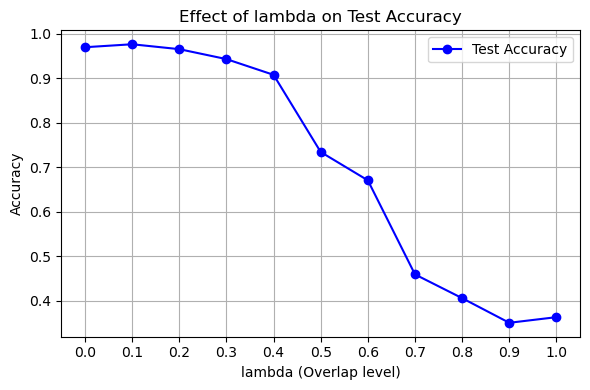

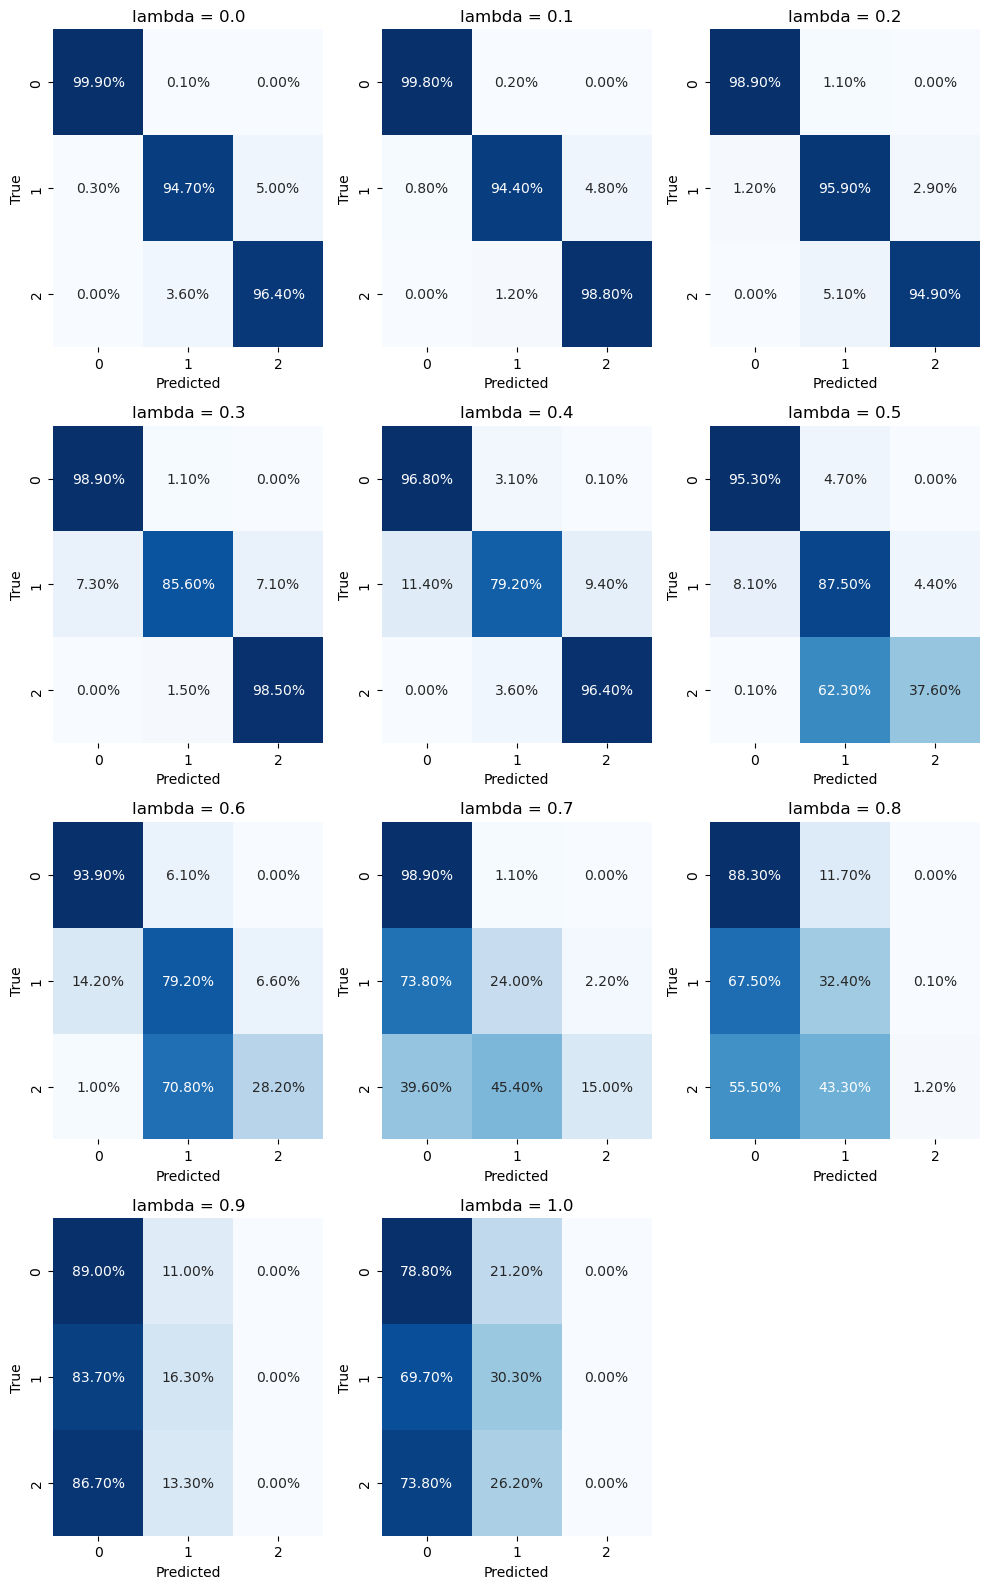

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
from sklearn.metrics import confusion_matrix

# 加载数据
data = io.loadmat('spikedata2.mat') 
X_all = data['X']  # (N, num_neurons, T)
Y_all = data['Y'].ravel()
lambda_all = data['lambda'].ravel()

num_neurons = X_all.shape[1]
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lambda 值
f_values = [0.1 * i for i in range(11)]
accuracies = []
conf_matrices = []

# 遍历每个 lambda，载入模型、预测并评估
for f in f_values:
    print(f"\n=== lambda = {f:.1f} ===")

    # 模型定义（确保 MultilayerSNN 类和 ms 单位已定义）
    net = MultilayerSNN((num_neurons, 100, num_classes),
                        [dict(tau=50 * ms, w_init=(-0.5, 0.7)),
                         dict(tau=500 * ms, spiking=False, w_init=(-0.01, 0.01))])
    net.to(device)

    # 加载模型权重
    model_path = f"zy_f{int(f * 10):02d}.pt"
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.eval()

    # 准备测试数据
    X_test, Y_test = [], []
    for cls in range(num_classes):
        indices = np.where((np.isclose(lambda_all, f)) & (Y_all == cls))[0]
        X_test.extend(X_all[indices])
        Y_test.extend(Y_all[indices])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    # Batch-wise prediction
    batch_size = 128
    preds = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            x_batch = X_test[i:i + batch_size]
            x_tensor = torch.tensor(x_batch, dtype=torch.float32).to(device)
            y_out = net(x_tensor)
            y_pred = torch.argmax(y_out[:, :, -1], dim=1)
            preds.extend(y_pred.cpu().numpy())

    preds = np.array(preds)
    acc = (preds == Y_test).mean()
    accuracies.append(acc)
    print(f"Test Accuracy: {acc:.2%}")

    # Confusion matrix
    cm = confusion_matrix(Y_test, preds, labels=np.arange(num_classes))
    conf_matrices.append(cm)

# 绘制准确率曲线
plt.figure(figsize=(6, 4))
plt.plot(f_values, accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("lambda (Overlap level)")
plt.ylabel("Accuracy")
plt.title("Effect of lambda on Test Accuracy")
plt.xticks(f_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 绘制 Confusion Matrix 图阵（每个 lambda 一张图）
fig, axes = plt.subplots(4, 3, figsize=(10, 16))
axes = axes.flatten()

for i, (f, cm) in enumerate(zip(f_values, conf_matrices)):
    ax = axes[i]
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"lambda = {f:.1f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# 删除多余子图
for j in range(len(f_values), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Next do the exploration of SHD Dataset